# Substitution Rates in GLMs: A Mathematical Guide to Ratio Confidence Intervals

## Introduction: The Power of Substitution Rates

When analyzing complex systems—whether in medicine, finance, or economics—we often need to answer questions like:
- "How many additional years of education compensate for one year less of work experience in salary determination?"
- "How much must we reduce cholesterol to offset a 10-point increase in blood pressure for cardiovascular risk?"
- "What increase in credit score compensates for $10,000 less in annual income for loan approval?"

These are questions about **substitution rates**—the rate at which we can trade one factor for another while maintaining the same outcome. Mathematically, these are ratios of coefficients in generalized linear models (GLMs).

## Prerequisites and Setup

### Required Packages
This notebook requires the following Python packages:
- `numpy` (>=1.19.0)
- `pandas` (>=1.2.0)
- `statsmodels` (>=0.12.0)
- `matplotlib` (>=3.3.0)
- `seaborn` (>=0.11.0)
- `scipy` (>=1.6.0)

Install them using:
```bash
pip install numpy pandas statsmodels matplotlib seaborn scipy
```

### Execution Order
**Important**: This notebook should be executed sequentially from top to bottom. Each cell builds upon previous results, particularly:
1. Import statements must be run first
2. Data loading must complete before model fitting
3. Model fitting must complete before calculating confidence intervals

### Data Availability
This notebook uses the Framingham Heart Study dataset. If the automatic download fails, you can:
1. Download the dataset manually from [GitHub](https://github.com/GauravPadawe/Framingham-Heart-Study)
2. The notebook will automatically fall back to simulated data for demonstration purposes

## The Mathematical Foundation

### 1. Substitution Rates in GLMs

Consider a GLM with link function $g$ and linear predictor:

$$g(\mathbb{E}[Y|X]) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p$$

If we want to maintain the same expected outcome when changing $X_1$ and $X_2$, we need:

$$\beta_1 \Delta X_1 + \beta_2 \Delta X_2 = 0$$

This gives us the substitution rate:

$$\frac{\Delta X_2}{\Delta X_1} = -\frac{\beta_1}{\beta_2}$$

**Interpretation**: To compensate for a one-unit decrease in $X_1$, we need to increase $X_2$ by $\frac{\beta_1}{\beta_2}$ units.

### 2. The Challenge: Uncertainty in Ratios

While point estimates of ratios are straightforward, constructing confidence intervals is challenging because:
1. The ratio $r = \frac{\beta_1}{\beta_2}$ is a nonlinear function of random variables
2. When $\beta_2 \approx 0$, the ratio becomes unstable
3. The sampling distribution of ratios can be highly skewed

### ⚠️ Important Considerations for Using Ratios

Before calculating substitution rates, ensure that:

1. **Both variables have meaningful units**: Ratios are most interpretable when both variables share the same scale or have comparable units. For example:
   - ✅ Good: Blood pressure (mmHg) vs. cholesterol (mg/dL) - both are clinical measurements
   - ❌ Poor: Age (years) vs. income (dollars) - very different scales and interpretations

2. **The denominator coefficient is significantly different from zero**: If $\beta_2 \approx 0$, the ratio becomes unstable and confidence intervals may be infinite.

3. **The relationship makes conceptual sense**: Ask yourself:
   - Can we actually substitute one variable for another in practice?
   - Is there a theoretical basis for this trade-off?
   - Would domain experts find this ratio meaningful?

4. **Variables are on appropriate scales**: Consider standardizing variables if they have vastly different scales to make ratios more interpretable.

5. **Model assumptions are met**: The validity of ratio inference depends on the underlying GLM being correctly specified.

## Mathematical Methods for Ratio Confidence Intervals

### Method 1: Delta Method (Wald-type CI)

The delta method uses a first-order Taylor expansion to approximate the variance of a nonlinear function.

For $r = \frac{\beta_1}{\beta_2}$, the gradient is:

$$\nabla r = \left[\frac{\partial r}{\partial \beta_1}, \frac{\partial r}{\partial \beta_2}\right] = \left[\frac{1}{\beta_2}, -\frac{\beta_1}{\beta_2^2}\right]$$

The approximate variance is:

$$\text{Var}(r) \approx \nabla r^T \Sigma \nabla r$$

where $\Sigma$ is the covariance matrix of $(\beta_1, \beta_2)$.

Expanding this:

$$\text{Var}(r) \approx \frac{1}{\beta_2^2}\text{Var}(\beta_1) + \frac{\beta_1^2}{\beta_2^4}\text{Var}(\beta_2) - 2\frac{\beta_1}{\beta_2^3}\text{Cov}(\beta_1, \beta_2)$$

The $(1-\alpha)100\%$ confidence interval is:

$$\hat{r} \pm z_{1-\alpha/2}\sqrt{\text{Var}(r)}$$

### Method 2: Fieller's Method

Fieller's method doesn't approximate the ratio directly but instead considers the set of all $r$ values for which we cannot reject:

$$H_0: \beta_1 - r\beta_2 = 0$$

This leads to solving:

$$\frac{(\hat{\beta}_1 - r\hat{\beta}_2)^2}{\text{Var}(\hat{\beta}_1 - r\hat{\beta}_2)} \leq \chi^2_{1,1-\alpha}$$

The solutions depend on the discriminant $\Delta = b^2 - ac$:
- If $\Delta \geq 0$ and $a > 0$: Finite interval
- If $\Delta \geq 0$ and $a < 0$: Union of two infinite intervals
- If $\Delta < 0$: Entire real line (no finite CI)

In [27]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass  # Fall back to default style
sns.set_palette("husl")

## Real-World Example: Medical Substitution Rates

Let's analyze how blood pressure and cholesterol interact in determining heart disease risk.

In [28]:
# Download and load the real Framingham Heart Study dataset
url = "https://github.com/GauravPadawe/Framingham-Heart-Study/blob/master/framingham.csv?raw=true"

try:
    heart_data = pd.read_csv(url)
    print("Dataset loaded successfully from GitHub")
except Exception as e:
    print(f"Warning: Could not load data from URL: {e}")
    print("Please download the Framingham dataset manually from:")
    print("https://github.com/GauravPadawe/Framingham-Heart-Study")
    print("\nAlternatively, using simulated data for demonstration...")
    
    # Generate simulated data for demonstration if URL fails
    np.random.seed(42)
    n_samples = 4000
    
    # Simulated risk factors
    age = np.random.normal(50, 15, n_samples)
    systolic_bp = np.random.normal(130, 20, n_samples)
    cholesterol = np.random.normal(200, 40, n_samples)
    
    # Simulated heart disease outcome (logistic relationship)
    logit = -8 + 0.01 * systolic_bp + 0.005 * cholesterol + 0.05 * age
    prob = 1 / (1 + np.exp(-logit))
    heart_disease = np.random.binomial(1, prob)
    
    heart_data = pd.DataFrame({
        'heart_disease': heart_disease,
        'systolic_bp': systolic_bp,
        'cholesterol': cholesterol,
        'age': age
    })
    print("Using simulated data for demonstration")

# Rename columns to match the rest of the notebook (if needed)
if 'TenYearCHD' in heart_data.columns:
    heart_data = heart_data.rename(columns={
        'TenYearCHD': 'heart_disease',
        'sysBP': 'systolic_bp',
        'totChol': 'cholesterol'
    })

# Drop rows with missing values in the columns used for the analysis
print(f"\nOriginal dataset shape: {heart_data.shape}")
heart_data.dropna(subset=['heart_disease', 'systolic_bp', 'cholesterol'], inplace=True)
print(f"Shape after dropping NaNs in key columns: {heart_data.shape}")

print(f"\nHeart disease prevalence: {heart_data['heart_disease'].mean():.3f}")
print("\nFirst 5 rows of the dataset:")
print(heart_data.head())
print("\nColumn names:", heart_data.columns.tolist())

Dataset loaded successfully from GitHub

Original dataset shape: (4240, 16)
Shape after dropping NaNs in key columns: (4190, 16)

Heart disease prevalence: 0.152

First 5 rows of the dataset:
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  cholesterol  systolic_bp  diaBP    BMI  heartRate  \
0             0         0        195.0        106.0   70.0  26.97       80.0   
1             0         0        250.0        121.0   81.0  28.73       95.0   
2             0         0        245.0        127.5   80.0  25.34       75.0   
3            

In [29]:
# Fit logistic regression
model = smf.glm('heart_disease ~ systolic_bp + cholesterol', 
                data=heart_data, family=sm.families.Binomial()).fit()

print("Logistic Regression Results:")
print(model.summary())

Logistic Regression Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:          heart_disease   No. Observations:                 4190
Model:                            GLM   Df Residuals:                     4187
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1689.1
Date:                Fri, 25 Jul 2025   Deviance:                       3378.1
Time:                        16:58:21   Pearson chi2:                 4.17e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04357
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.526

In [30]:
# Extract coefficients
beta_bp = model.params['systolic_bp']
beta_chol = model.params['cholesterol']
cov_matrix = model.cov_params()

# Calculate substitution rate
substitution_rate = beta_bp / beta_chol
print(f"Substitution Rate (BP/Cholesterol): {substitution_rate:.4f}")
print(f"Interpretation: A 1-unit increase in cholesterol can be offset by a")
print(f"{substitution_rate:.4f}-unit decrease in systolic blood pressure")

Substitution Rate (BP/Cholesterol): 9.0122
Interpretation: A 1-unit increase in cholesterol can be offset by a
9.0122-unit decrease in systolic blood pressure


### Implementing Different CI Methods

Now let's implement the key methods for computing confidence intervals on ratios.

In [31]:
def delta_method_ci(beta1, beta2, cov_matrix, alpha=0.05):
    """Delta method confidence interval for ratio beta1/beta2"""
    var_beta1 = cov_matrix.iloc[0, 0]
    var_beta2 = cov_matrix.iloc[1, 1]
    cov_beta12 = cov_matrix.iloc[0, 1]
    
    ratio = beta1 / beta2
    
    # Variance of ratio using delta method
    var_ratio = (1/beta2**2) * var_beta1 + (beta1**2/beta2**4) * var_beta2 - \
                2 * (beta1/beta2**3) * cov_beta12
    
    se_ratio = np.sqrt(var_ratio)
    z_crit = stats.norm.ppf(1 - alpha/2)
    
    ci_lower = ratio - z_crit * se_ratio
    ci_upper = ratio + z_crit * se_ratio
    
    return ci_lower, ci_upper, se_ratio

def fieller_ci(beta1, beta2, cov_matrix, alpha=0.05):
    """Fieller's method confidence interval"""
    var_beta1 = cov_matrix.iloc[0, 0]
    var_beta2 = cov_matrix.iloc[1, 1]
    cov_beta12 = cov_matrix.iloc[0, 1]
    
    chi2_crit = stats.chi2.ppf(1 - alpha, df=1)
    
    a = beta2**2 - chi2_crit * var_beta2
    b = -beta1 * beta2 + chi2_crit * cov_beta12
    c = beta1**2 - chi2_crit * var_beta1
    
    discriminant = b**2 - a*c
    
    if discriminant < 0:
        return -np.inf, np.inf
    
    sqrt_disc = np.sqrt(discriminant)
    
    if a > 0:
        ci_lower = (-b - sqrt_disc) / a
        ci_upper = (-b + sqrt_disc) / a
        return ci_lower, ci_upper
    else:
        # Union of two intervals
        root1 = (-b - sqrt_disc) / a
        root2 = (-b + sqrt_disc) / a
        return ((-np.inf, min(root1, root2)), (max(root1, root2), np.inf))

In [32]:
# Apply methods
# Extract relevant part of covariance matrix
cov_subset = cov_matrix.loc[['systolic_bp', 'cholesterol'], ['systolic_bp', 'cholesterol']]

delta_ci = delta_method_ci(beta_bp, beta_chol, cov_subset)
print(f"Delta Method CI: [{delta_ci[0]:.4f}, {delta_ci[1]:.4f}]")
print(f"Standard Error: {delta_ci[2]:.4f}")

fieller_result = fieller_ci(beta_bp, beta_chol, cov_subset)
if isinstance(fieller_result[0], tuple):
    print(f"Fieller's CI: Union of ({fieller_result[0][0]:.4f}, {fieller_result[0][1]:.4f}) and ({fieller_result[1][0]:.4f}, {fieller_result[1][1]:.4f})")
else:
    print(f"Fieller's CI: [{fieller_result[0]:.4f}, {fieller_result[1]:.4f}]")

Delta Method CI: [2.0173, 16.0071]
Standard Error: 3.5689
Fieller's CI: [4.9174, 34.8348]


### Visualization of Substitution Rates

Let's create visualizations to understand the substitution concept better.

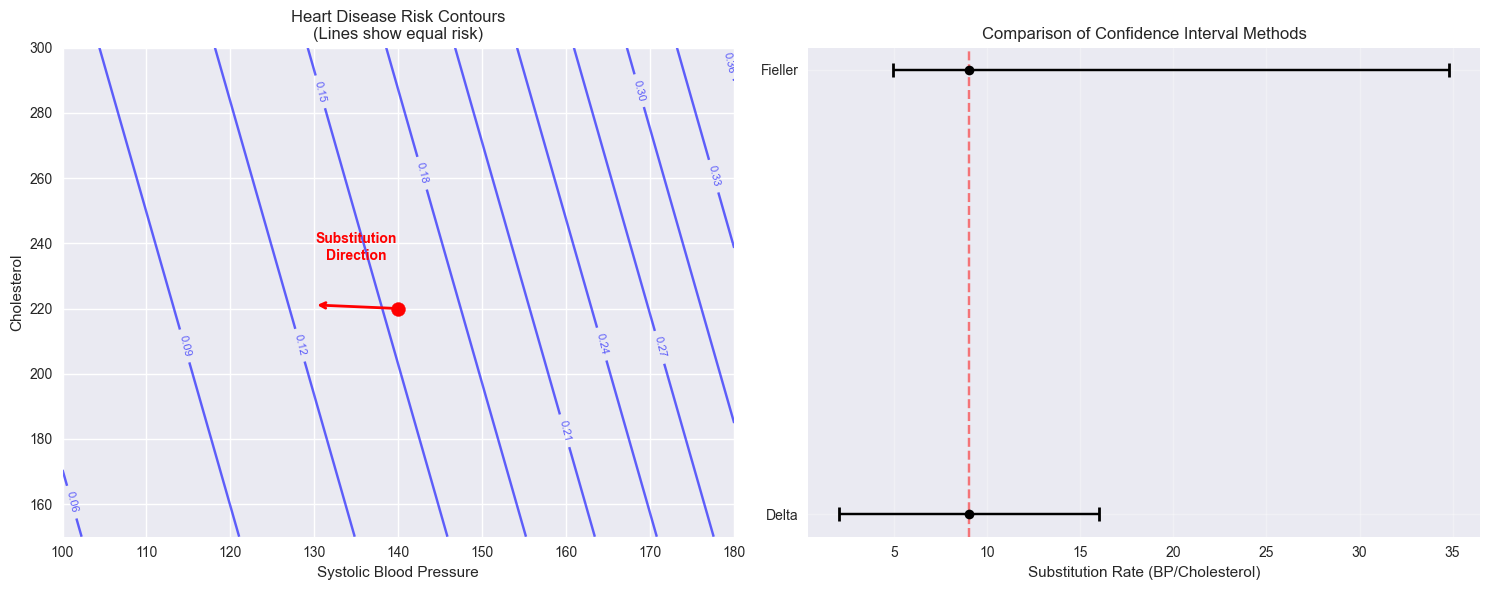

In [33]:
# Create visualization showing the substitution rate concept
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Contour plot showing equal risk curves
bp_range = np.linspace(100, 180, 100)
chol_range = np.linspace(150, 300, 100)
BP, CHOL = np.meshgrid(bp_range, chol_range)

# Calculate log-odds for each combination
log_odds = model.params['Intercept'] + beta_bp * BP + beta_chol * CHOL
risk = 1 / (1 + np.exp(-log_odds))

contour = ax1.contour(BP, CHOL, risk, levels=10, colors='blue', alpha=0.6)
ax1.clabel(contour, inline=True, fontsize=8)
ax1.set_xlabel('Systolic Blood Pressure')
ax1.set_ylabel('Cholesterol')
ax1.set_title('Heart Disease Risk Contours\n(Lines show equal risk)')

# Add arrow showing substitution
bp_point = 140
chol_point = 220
ax1.scatter(bp_point, chol_point, color='red', s=100, zorder=5)
ax1.annotate('', xy=(bp_point - 10, chol_point + 10/substitution_rate), 
             xytext=(bp_point, chol_point),
             arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax1.text(bp_point - 5, chol_point + 15, 'Substitution\nDirection', 
         ha='center', color='red', fontsize=10, fontweight='bold')

# Plot 2: Confidence intervals comparison
methods = ['Delta', 'Fieller']
point_est = [substitution_rate, substitution_rate]
lower_bounds = [delta_ci[0], fieller_result[0] if not isinstance(fieller_result[0], tuple) else fieller_result[0][1]]
upper_bounds = [delta_ci[1], fieller_result[1] if not isinstance(fieller_result[0], tuple) else fieller_result[1][0]]

y_pos = np.arange(len(methods))
ax2.errorbar(point_est, y_pos, 
             xerr=[np.array(point_est) - np.array(lower_bounds), 
                   np.array(upper_bounds) - np.array(point_est)],
             fmt='o', color='black', capsize=5, capthick=2)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(methods)
ax2.axvline(x=substitution_rate, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Substitution Rate (BP/Cholesterol)')
ax2.set_title('Comparison of Confidence Interval Methods')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Analyzing sensitivity to sample size...
Sample size: 100
Sample size: 200
Sample size: 500
Sample size: 1000
Sample size: 2000


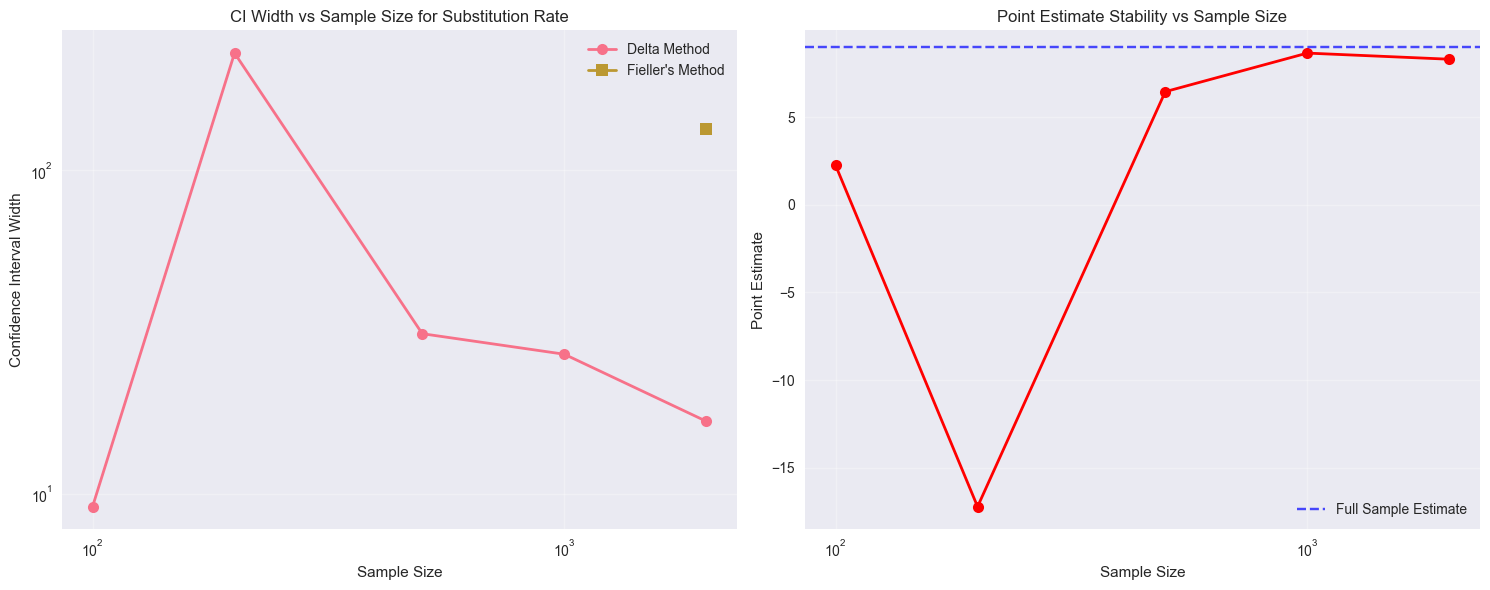

In [34]:
# Analyze how ratio CI width changes with sample size
sample_sizes = [100, 200, 500, 1000, 2000]
ci_widths_delta = []
ci_widths_fieller = []
point_estimates = []

print("Analyzing sensitivity to sample size...")

for n in sample_sizes:
    print(f"Sample size: {n}")
    
    # Subsample data
    subsample = heart_data.sample(n=min(n, len(heart_data)), replace=True, random_state=42)
    
    # Fit model
    sub_model = smf.glm('heart_disease ~ systolic_bp + cholesterol', 
                        data=subsample, family=sm.families.Binomial()).fit()
    
    # Get coefficients and covariance
    beta1 = sub_model.params['systolic_bp']
    beta2 = sub_model.params['cholesterol']
    cov_subset = sub_model.cov_params().loc[['systolic_bp', 'cholesterol'], 
                                           ['systolic_bp', 'cholesterol']]
    
    point_estimates.append(beta1 / beta2)
    
    # Calculate CIs
    try:
        delta_ci = delta_method_ci(beta1, beta2, cov_subset)
        ci_widths_delta.append(delta_ci[1] - delta_ci[0])
    except:
        ci_widths_delta.append(np.nan)
    
    try:
        fieller_result = fieller_ci(beta1, beta2, cov_subset)
        if not isinstance(fieller_result[0], tuple):
            ci_widths_fieller.append(fieller_result[1] - fieller_result[0])
        else:
            ci_widths_fieller.append(np.nan)
    except:
        ci_widths_fieller.append(np.nan)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# CI widths
ax1.plot(sample_sizes, ci_widths_delta, 'o-', label='Delta Method', linewidth=2, markersize=8)
ax1.plot(sample_sizes, ci_widths_fieller, 's-', label="Fieller's Method", linewidth=2, markersize=8)
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Confidence Interval Width')
ax1.set_title('CI Width vs Sample Size for Substitution Rate')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')

# Point estimates
ax2.plot(sample_sizes, point_estimates, 'o-', color='red', linewidth=2, markersize=8)
ax2.axhline(y=substitution_rate, color='blue', linestyle='--', alpha=0.7, label='Full Sample Estimate')
ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Point Estimate')
ax2.set_title('Point Estimate Stability vs Sample Size')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

## Summary and Recommendations

### When to Use Each Method:

1. **Delta Method**: 
   - ✅ Fast and simple
   - ✅ Works well when denominator is far from zero
   - ❌ Can be inaccurate for small samples or near-zero denominators

2. **Fieller's Method**: 
   - ✅ Exact under normality assumptions
   - ✅ Properly handles near-zero denominators
   - ❌ Can produce infinite intervals

3. **Bootstrap Methods**: 
   - ✅ Fewer distributional assumptions
   - ✅ Can capture skewness
   - ❌ Computationally intensive

### Key Takeaways:

1. **Substitution rates provide meaningful interpretations** in many domains—from clinical decision-making to financial risk assessment.

2. **No single method dominates** all scenarios. Choose based on:
   - Sample size
   - Proximity of denominator to zero
   - Computational resources
   - Interpretability requirements

3. **Always check stability diagnostics** before interpreting ratio estimates.

4. **Consider multiple methods** for important decisions, especially when the denominator coefficient has high uncertainty.

5. **Bootstrap methods provide a good default** when computational resources allow, as they make fewer assumptions.